In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import os 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
# Ionpy imports
from ionpy.analysis import ResultsLoader
# Local imports
from ese.analysis.analyze_inf import load_cal_inference_stats
from ese.analysis.analysis_utils.plot_utils import get_prop_color_palette
from ese.analysis.analysis_utils.parse_sweep import get_global_optimal_parameter, get_per_subject_optimal_values
sns.set_style("darkgrid")
sns.set_context("talk")
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
root = Path("/storage/vbutoi/scratch/ESE")
pd.set_option('display.max_rows', 50)
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/hdd/home/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: '/storage/vbutoi/scratch/ESE/inference/11_05_24_UVS_InContext_CrossEval'
    inference_group: 
        - 'Sweep_Threshold'
        # - 'Sweep_Temperature'

options:
    verify_graceful_exit: True
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

### Useful cell for controlling the plotting functions.

In [14]:
# ######This cells controls what gets plotted in the following cells so we don't have to change each one
x_key = 'threshold'
y_key = 'hard_RAVE'
xtick_range = np.arange(0, 1.1, 0.1)
cmap = 'viridis_r'
aspect = 1
x_lims = (0, 1)
y_lims = (0.0, 2)

# x_key = 'temperature'
# y_key = 'soft_RAVE'
# xtick_range = np.arange(0, 3.1, 0.1)
# cmap = 'magma_r'
# aspect = 2
# x_lims = (0, 3.0)
# y_lims = (-0.5, 2)

# Plotting Calls

In [4]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True
)

/storage/vbutoi/scratch/ESE/inference/11_05_24_UVS_InContext_CrossEval/Sweep_Threshold  20241105_011331-M2MC-863dcfaeb997edbae01b69e73ba5e3c4     5000
                                                                                        20241105_011336-2U6V-7460588958f18a8c1a6db15746e5ac29     5000
                                                                                        20241105_011340-4TIO-b13bc0d9b9bf0adaefd4154b9b1f527a     5000
                                                                                        20241105_011344-ER9T-4d09ca6cdcacf9a9a956fdaaba033364     5000
                                                                                        20241105_011436-NUKZ-d99e3038bce9ecbd5a42b555af2f3983    13600
                                                                                        20241105_011440-XNDG-ed3cd98174897a81c143775769b6e34c    13600
                                                                                        202411

In [5]:
# Only keep the rows where the image_metric is 'Dice'
inference_df = inference_df[inference_df['image_metric'] == 'Dice']
# Rename the column metric score for this new df to Dice
inference_df = inference_df.rename(columns={'metric_score': 'Dice'})

In [6]:
inference_df['split'] = 'train'

In [7]:
for ikey in inference_df.keys():
    print(ikey)

pred_hash
image_metric
Dice
from_logits
threshold
temperature
batch_idx
support_idx
data_cfg_str
data_id
data_key
gt_volume
soft_volume
hard_volume
new_gt_proportion
soft_proportion
hard_proportion
global_cal_metrics
image_cal_metrics
qual_metrics
log_set
slice_idx
dataloader_batch_size
dataloader_num_workers
dataloader_pin_memory
experiment_crosseval_incontex
experiment_exp_name
experiment_exp_root
experiment_inf_kwargs_from_logits
experiment_inf_kwargs_temperature
experiment_inf_kwargs_threshold
experiment_inference_seed
experiment_model_dir
experiment_num_supports
experiment_pretrained_seed
global_calibration_neighborhood_width
global_calibration_num_classes
global_calibration_num_prob_bins
inference_data_class
inference_data_label
inference_data_label_threshold
inference_data_min_label_density
inference_data_preload
inference_data_resolution
inference_data_return_data_id
inference_data_return_data_key
inference_data_slicing
inference_data_split
inference_data_support_size
inference

In [9]:
for task in inference_df['inference_data_task'].unique():
    print(task)

SCD/VIS_pig/MRI/2
STARE/retrieved_2021_12_06/Retinal/0
PanDental/v1/XRay/0
SCD/LAF_Pre/MRI/2
SCD/VIS_human/MRI/2
WBC/CV/EM/0
SpineWeb/Dataset7/MR/0
PanDental/v2/XRay/0
WBC/JTSC/EM/0
SCD/LAS/MRI/2
SCD/LAF_Post/MRI/2
ACDC/Challenge2017/MRI/2


In [10]:
cols_to_keep = [
    'soft_abs_area_estimation_error',
    'hard_abs_area_estimation_error',
    'soft_RAVE',
    'hard_RAVE',
    'log_soft_RAVE',
    'log_hard_RAVE',
    'Dice',
    'inference_data_task',
    'loss_func_class',
    'threshold',
    'temperature',
    'hard_volume',
    'soft_volume',
    'gt_volume',
    'data_id',
    'split'
]
# Filter out the columns we want to keep
exp_df = inference_df[cols_to_keep].drop_duplicates().reset_index(drop=True)

In [11]:
# We need to make sure that the cal split goes first.
exp_df = exp_df.sort_values('split', ascending=True)

<Figure size 2160x1440 with 0 Axes>

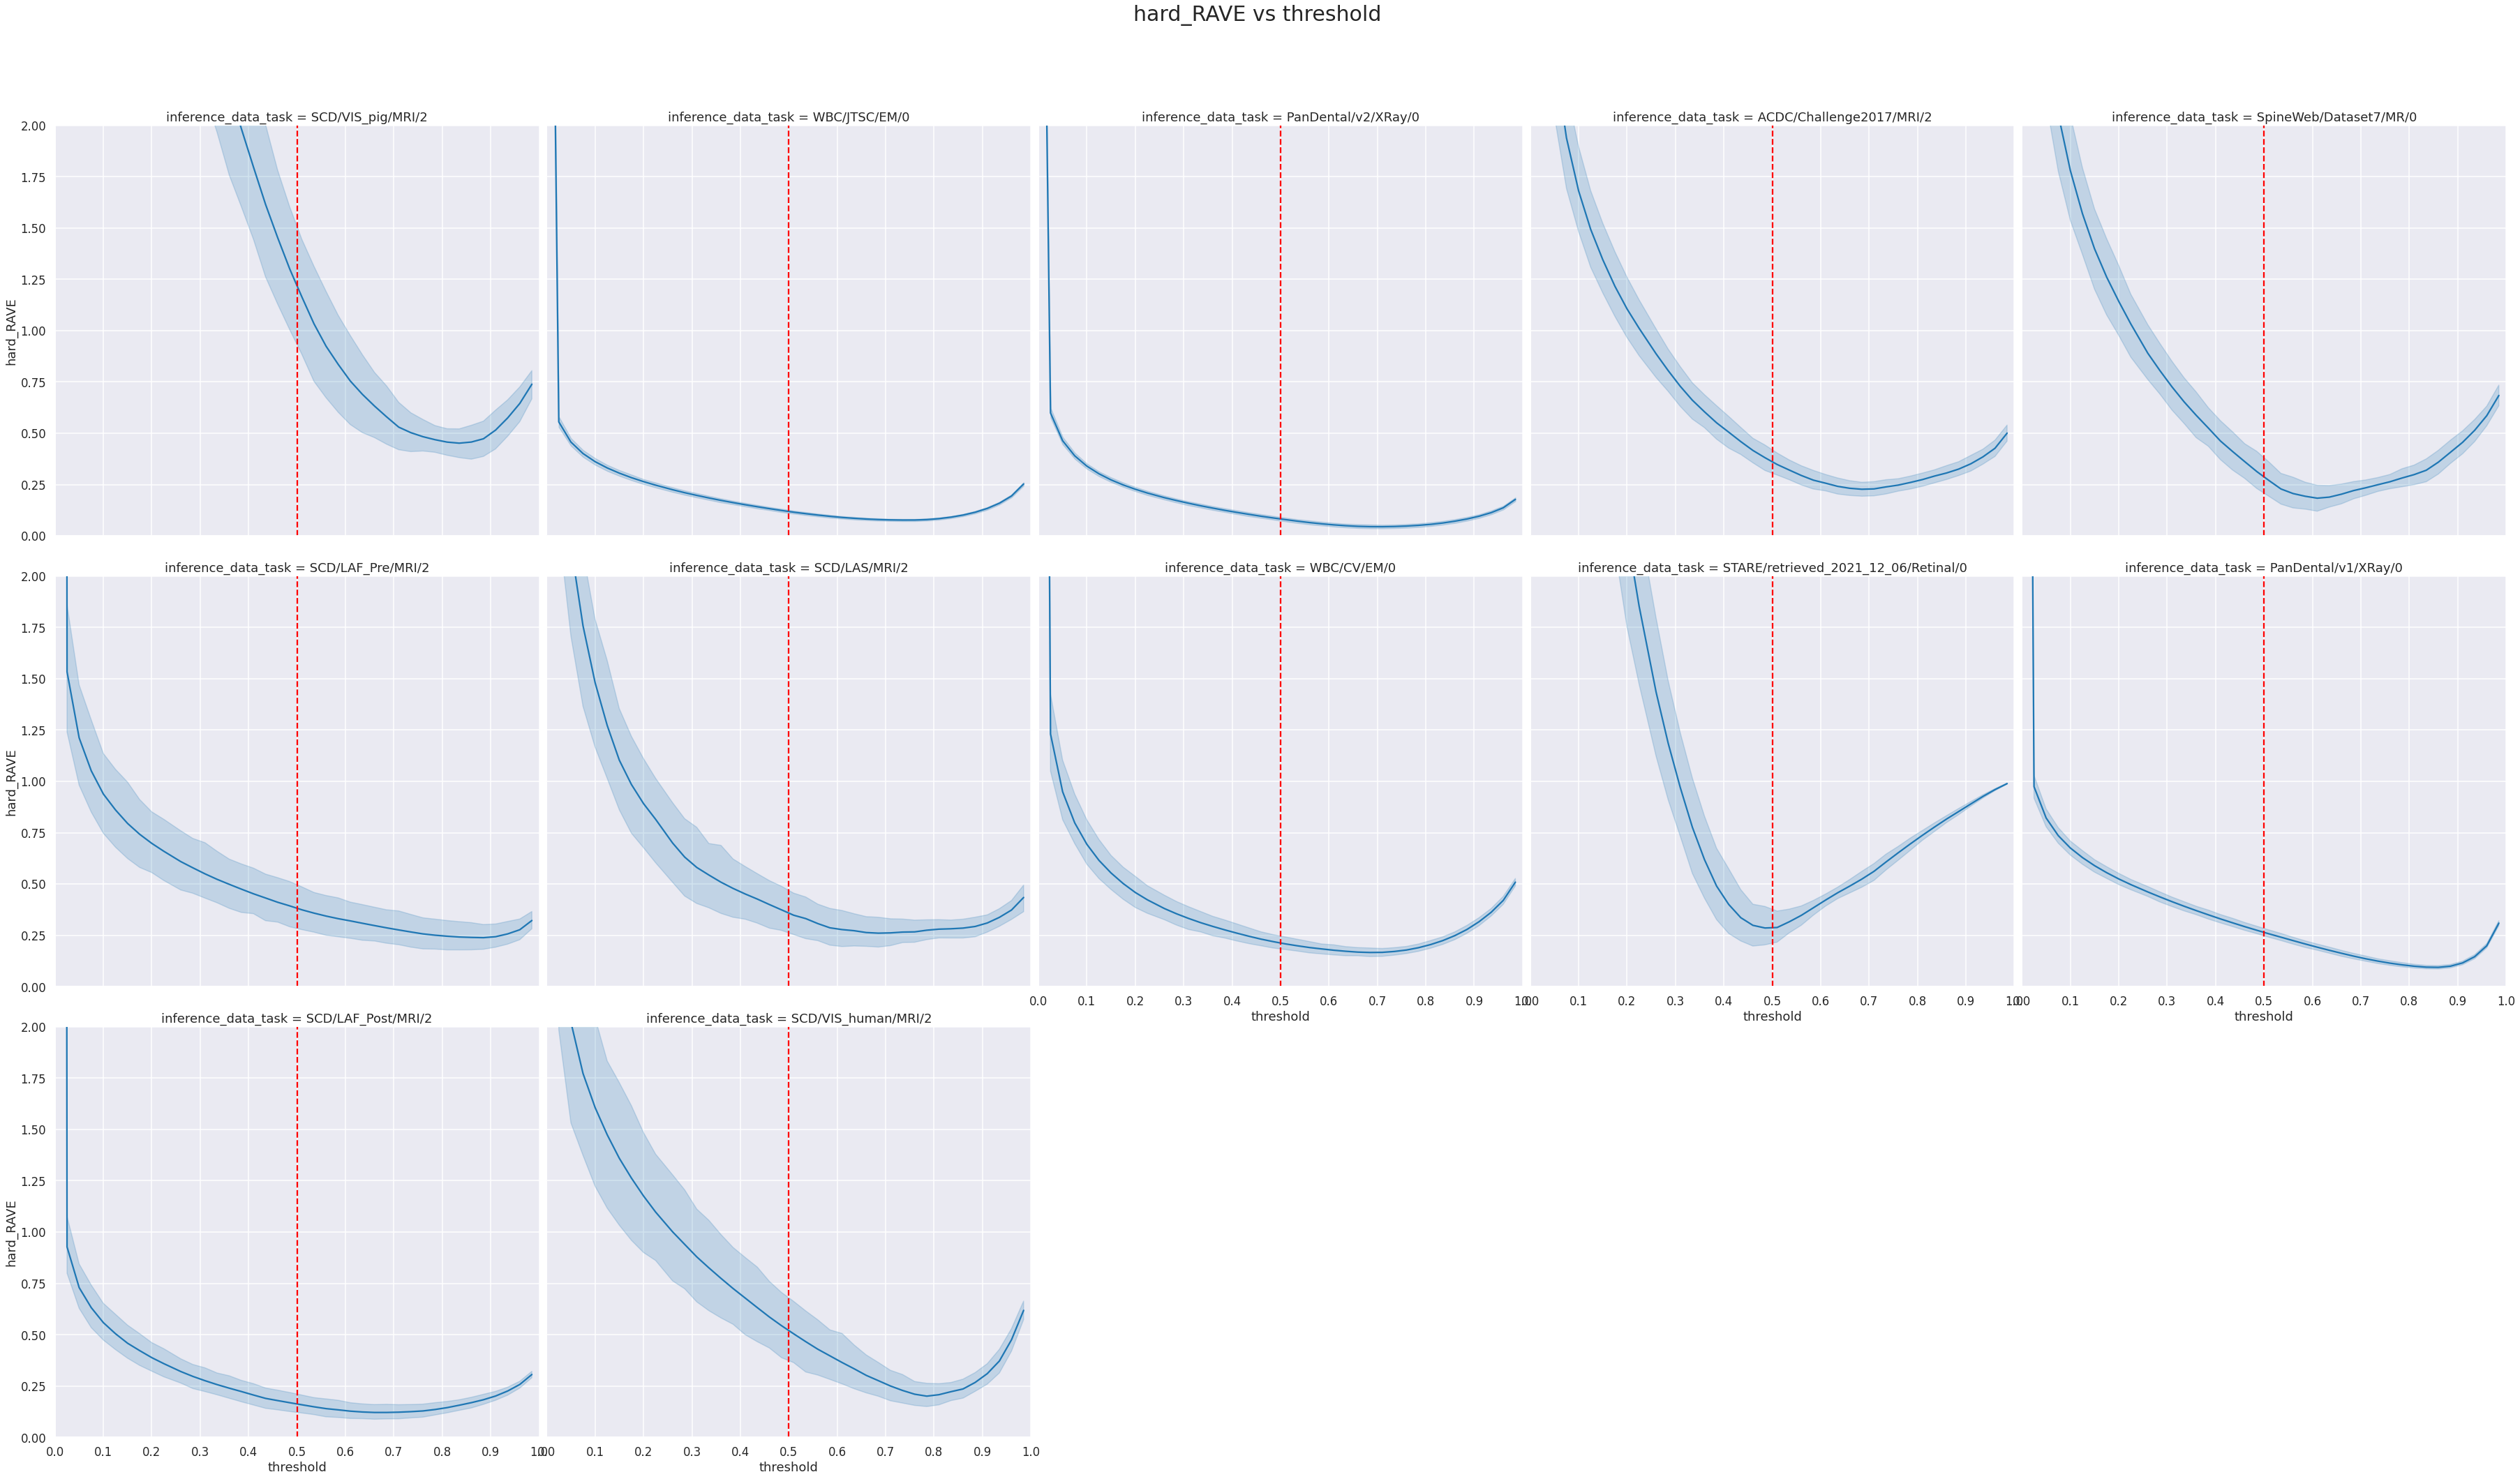

In [15]:
plt.figure(figsize=(30, 20))
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y=y_key,
    col='inference_data_task',
    col_wrap=5,
    kind='line',
    height=10,
    aspect=aspect,
)
# If the x_key is temperature, place a dashed red vertical line at 1.01
if x_key == 'temperature':
    for ax in g.axes.flat:
        ax.axvline(x=1.01, color='r', linestyle='--')
else:
    for ax in g.axes.flat:
        ax.axvline(x=0.5, color='r', linestyle='--')

g.set(xticks=xtick_range, xlim=x_lims, ylim=y_lims)
# Make a global title using suptitle with some spacing
plt.suptitle(f'{y_key} vs {x_key}', fontsize=30)
# Add spacing between the title and the plot
plt.subplots_adjust(top=0.9)

<Figure size 2160x1440 with 0 Axes>

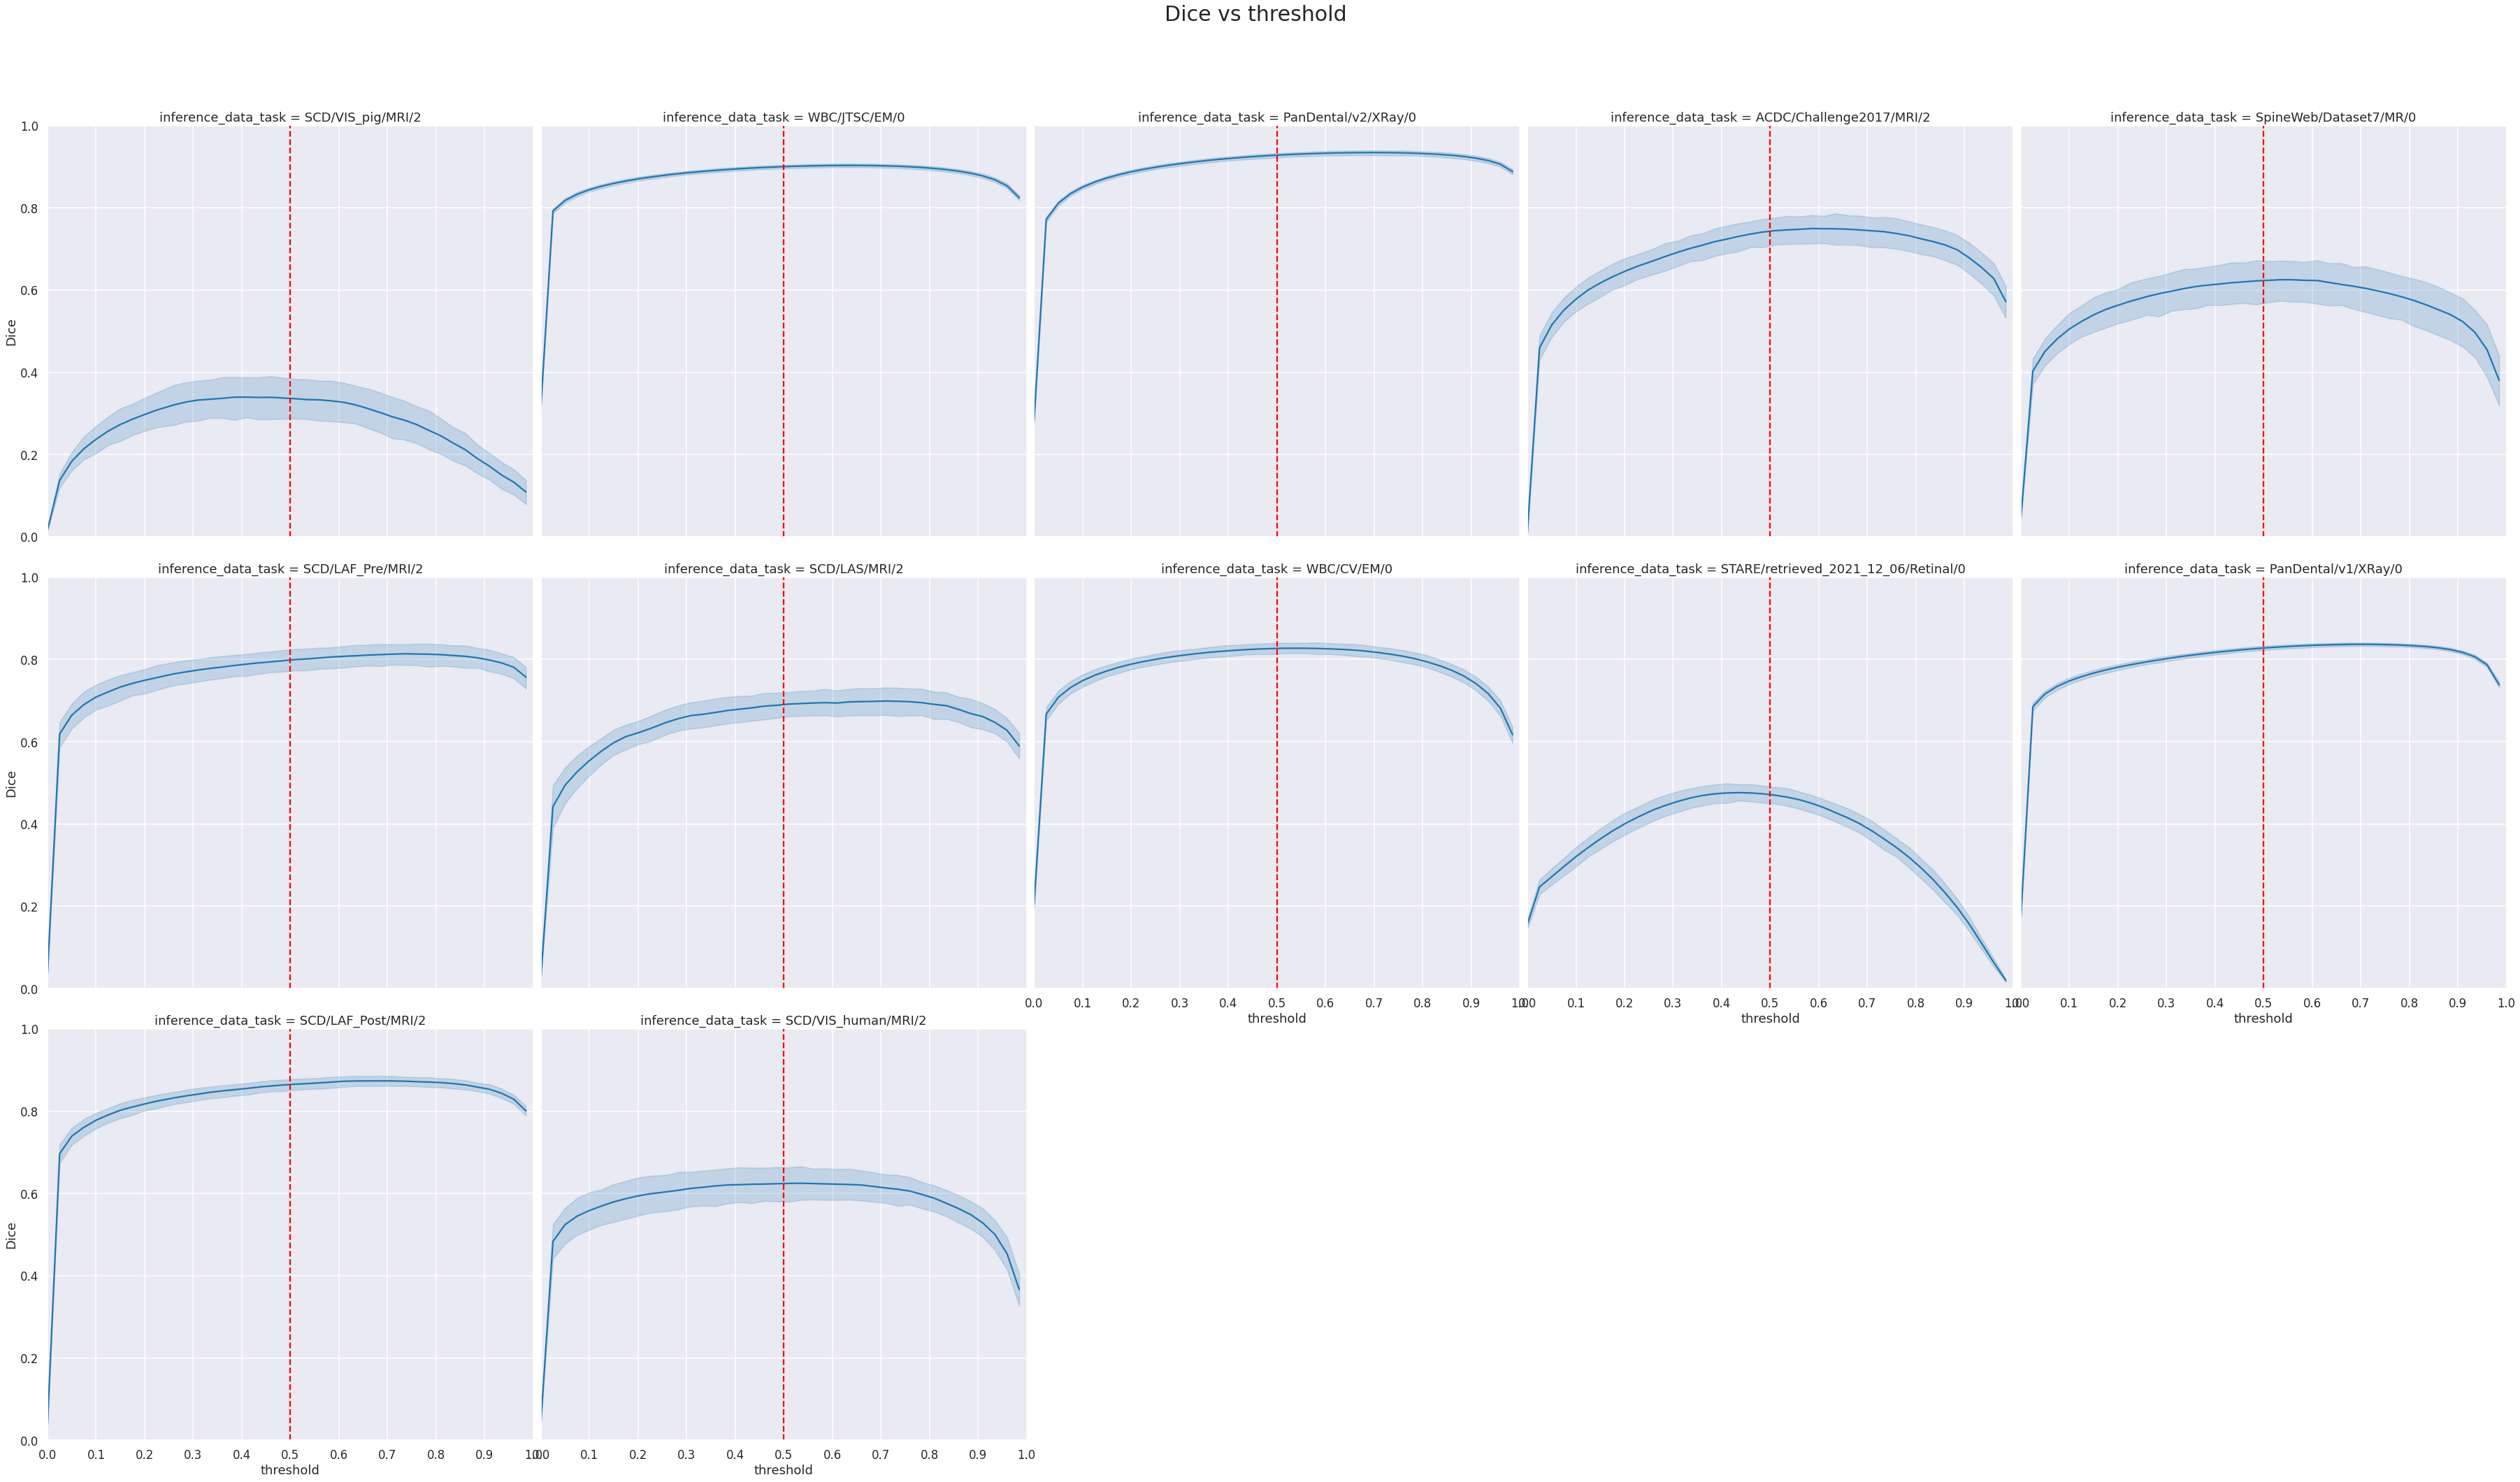

In [17]:
plt.figure(figsize=(30, 20))
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y='Dice',
    col='inference_data_task',
    col_wrap=5,
    kind='line',
    height=10,
    aspect=aspect,
    # legend=(x_key == 'temperature')
)
# If the x_key is temperature, place a dashed red vertical line at 1.01
if x_key == 'temperature':
    for ax in g.axes.flat:
        ax.axvline(x=1.01, color='r', linestyle='--')
else:
    for ax in g.axes.flat:
        ax.axvline(x=0.5, color='r', linestyle='--')

g.set(xticks=xtick_range, xlim=x_lims, ylim=[0, 1])
# Make a global title using suptitle with some spacing
plt.suptitle(f'Dice vs {x_key}', fontsize=30)
# Add spacing between the title and the plot
plt.subplots_adjust(top=0.9)